In [1]:
import warnings, logging, os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings('ignore')

In [2]:

import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
import numpy as np
import matplotlib.pyplot as plt

tfds.disable_progress_bar()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
tf.__version__, tf.keras.__version__, tf.test.is_gpu_available()

('2.8.0', '2.8.0', False)

___

## LOAD MNIST DATA

Data set with handwritten numbers images from 0 to 9

We will train a neural net able to classify new images as one of this 10 numbers with Keras - Tensorflow

___

In [5]:
training_set, dataset_info = tfds.load('mnist', split = 'train', as_supervised = True, with_info = True)

num_classes = dataset_info.features['label'].num_classes
print('\nThere are {:,} classes in our dataset'.format(num_classes))

num_training_examples = dataset_info.splits['train'].num_examples
print('\nThere are {:,} images in the training set'.format(num_training_examples))


There are 10 classes in our dataset

There are 60,000 images in the training set


The label of this image is: 4
The label of this image is: 1
The label of this image is: 0


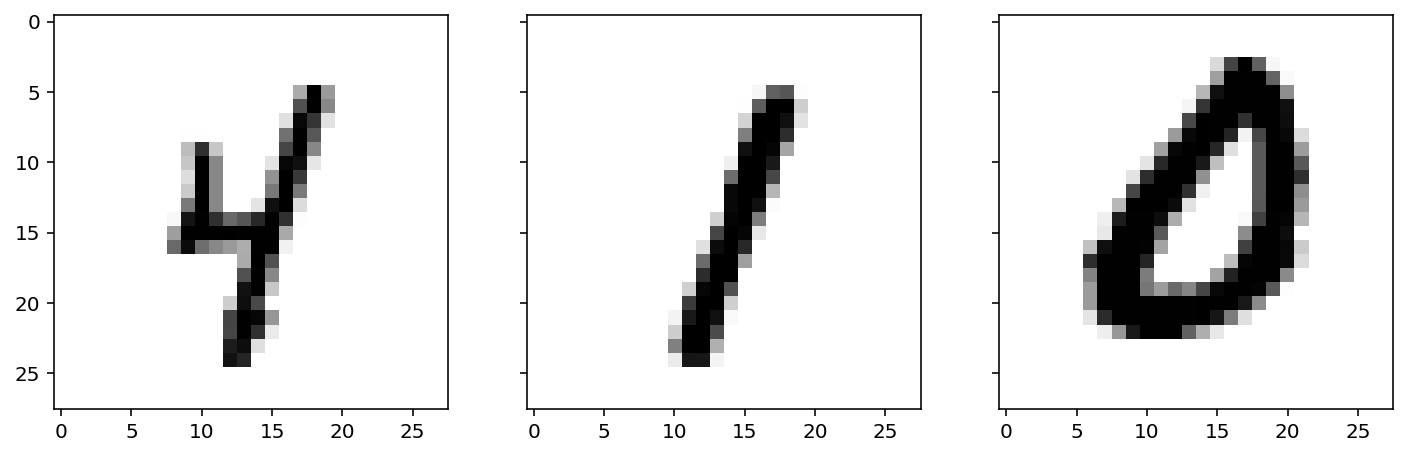

In [6]:
samples = 3
fig, axs = plt.subplots(1, samples, sharey=True, figsize=(samples*4, 4))

for i, samp in enumerate(training_set.take(samples)):
    image = samp[0].numpy().squeeze()
    label = samp[1].numpy()
    
    # Plot some images
    axs[i].imshow(image, cmap = plt.cm.binary)
    print('The label of this image is:', label)
    
plt.show()

___

## PIPELINE

- caching the dataset, because MNIST is a small one we can do this

- shuffling in order to prevent nets tu memorize our data

- batch small enough so we don't have a slow training time but bigger enough to achieve the accurracy we're aiming

- prefetch to load next batch while we process the current batch

___

In [7]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255 # normalize the pixel value
    return image, label

batch_size = 64
training_batches = training_set.cache()\
                .shuffle(num_training_examples//4)\
                .batch(batch_size)\
                .map(normalize).prefetch(1)

In [8]:
# we have our `training_batches` now let's inspect them:
for image_batch, label_batch in training_batches.take(1):
    print('The images in each batch have:')
    print('\u2022 dtype:', image_batch.dtype) 
    print('\u2022 shape:', image_batch.shape)

    print('\nThere are a total of {} image labels in this batch:'.format(label_batch.numpy().size))
    print(label_batch.numpy())

The images in each batch have:
• dtype: <dtype: 'float32'>
• shape: (64, 28, 28, 1)

There are a total of 64 image labels in this batch:
[0 2 4 8 2 1 3 9 1 6 7 6 3 2 6 7 6 5 1 0 8 3 9 2 7 0 3 0 3 7 3 8 5 8 0 1 9
 4 4 4 3 8 5 7 1 5 8 6 0 8 4 9 4 8 2 6 3 8 6 1 5 1 8 0]


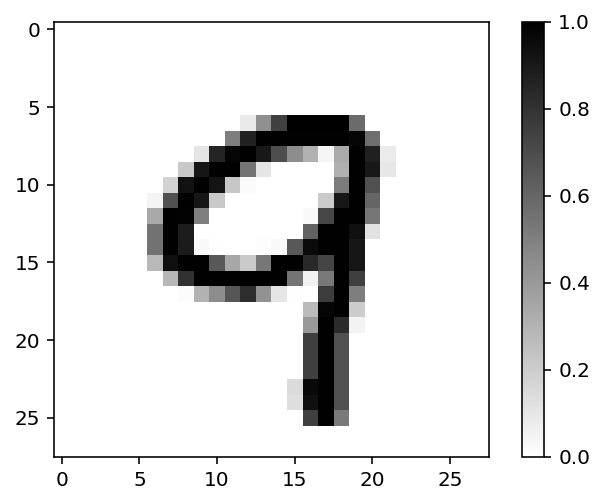

The label of this image is: 9


In [9]:
# take a single batch of images, and remove the color dimension by squeezing it
for image_batch, label_batch in training_batches.take(1):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

# Plot the image
plt.imshow(images[0], cmap = plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', labels[0])

___

We need 10 output units, one for each digit, we want our network to predict the digit shown in an image. 

What we'll do, is calculate the probabilities that the image is of any one digit or class.

This ends up being a discrete probability distribution over the classes (digits) that tells us the most likely class for the image.

So we'll need to "flatten" the batch of images we've created. Then build a simple network with **784 input units**, **256 hidden units**, and **10 output units** using random tensors for the weights and biases. 

For now, we use a sigmoid activation function for the units in the hidden layer and leave the output layer without an activation, we'll add one that gives us a probability distribution next. 
____

In [10]:
def sigmoid_activation(x):
    return 1/(1+tf.exp(-x))

# flatten input images
inputs = tf.reshape(images, [images.shape[0], -1])

# Neural Network parameters
w1 = tf.random.normal((784,256))
b1 = tf.random.normal((1,256))

w2 = tf.random.normal((256,10))
b2 = tf.random.normal((1,10))

# matrix multiplications for the hidden layer and apply activation function
h = sigmoid_activation(tf.matmul(inputs, w1) + b1)

# matrix multiplication for the output layer
output = tf.matmul(h, w2) + b2

print('The inputs have shape:', inputs.shape)
print('The output has shape:', output.shape)

The inputs have shape: (64, 784)
The output has shape: (64, 10)


___

So now that we have 10 outputs for our network, we wanna pass in an image and get a probability distribution over the classes that tells us the most likely class the image belongs to

To calculate this probability distribution, we often use the SoftMax
___

In [11]:
def softmax(x):
    return tf.exp(x) / tf.reduce_sum(tf.exp(x), axis = 1, keepdims = True)

probabilities = softmax(output)

sum_all_prob = tf.reduce_sum(probabilities, axis = 1).numpy()

for i, prob_sum in enumerate(sum_all_prob):
    print('Sum of probabilities for Image {}: {:.1f}'.format(i+1, prob_sum))

Sum of probabilities for Image 1: 1.0
Sum of probabilities for Image 2: 1.0
Sum of probabilities for Image 3: 1.0
Sum of probabilities for Image 4: 1.0
Sum of probabilities for Image 5: 1.0
Sum of probabilities for Image 6: 1.0
Sum of probabilities for Image 7: 1.0
Sum of probabilities for Image 8: 1.0
Sum of probabilities for Image 9: 1.0
Sum of probabilities for Image 10: 1.0
Sum of probabilities for Image 11: 1.0
Sum of probabilities for Image 12: 1.0
Sum of probabilities for Image 13: 1.0
Sum of probabilities for Image 14: 1.0
Sum of probabilities for Image 15: 1.0
Sum of probabilities for Image 16: 1.0
Sum of probabilities for Image 17: 1.0
Sum of probabilities for Image 18: 1.0
Sum of probabilities for Image 19: 1.0
Sum of probabilities for Image 20: 1.0
Sum of probabilities for Image 21: 1.0
Sum of probabilities for Image 22: 1.0
Sum of probabilities for Image 23: 1.0
Sum of probabilities for Image 24: 1.0
Sum of probabilities for Image 25: 1.0
Sum of probabilities for Image 26:

___

## KERAS

high-level API to build and train neural networks

In Keras, deep learning models are constructed by connecting configurable building blocks called **layers**. The most common type of model is a stack of layers called a **Sequential** model (because it allows a tensor to be passed sequentially through the operations in each layer). In TensorFlow, the sequential model is implemented with `tf.keras.Sequential`.

We'll use a Keras sequential model to build the same **fully-connected neural network** we built previously. Our sequential model will have three layers:

* **Input Layer:** `tf.keras.layers.Flatten` — This layer flattens the images by transforming a 2d-array of 28x28 pixels, to a 1d-array of 784 pixels. The first layer in a Sequential model needs to know the shape of the input tensors to the model. The `input_shape` is specified using a tuple that contains the size of our images and the number of color channels.

* **Hidden Layer:** `tf.keras.layers.Dense` — A fully-connected (also known as densely connected) layer. For this layer we need to specify the number of neurons (or nodes) we want to use and the activation function. Note that we don't have to specify the shape of the input tensor to this layer, since Keras performs automatic shape inference for all layers except for the first layer.

* **Output Layer:** `tf.keras.layers.Dense` — A fully-connected layer with 10 neurons and a *softmax* activation function. The output values will represent the probability that the image is a particular digit. The sum of all the 10 nodes values is 1.

___

In [12]:
model = tf.keras.Sequential([
                tf.keras.layers.Flatten(input_shape = (28,28,1)),
                tf.keras.layers.Dense(256, activation = 'sigmoid'),
                tf.keras.layers.Dense(10, activation = 'softmax')
        ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_2 = tf.keras.Sequential([
             tf.keras.layers.Flatten(input_shape = (28,28,1)),
             tf.keras.layers.Dense(128, activation = 'relu'),
             tf.keras.layers.Dense(64, activation = 'relu'),
             tf.keras.layers.Dense(10, activation = 'softmax')
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [14]:
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        w = layer.get_weights()[0]
        b = layer.get_weights()[1]
        
        print('Layer {}: {}\n'.format(i, layer.name))
        print('This layer has a total of {:,} weights and {:,} biases'.format(w.size, b.size))
        print('------------------------\n')
    
    else:
        print('Layer {}: {}\n'.format(i, layer.name))
        print('This layer has no weights or biases.')
        print('------------------------\n')

Layer 0: flatten

This layer has no weights or biases.
------------------------

Layer 1: dense

This layer has a total of 200,704 weights and 256 biases
------------------------

Layer 2: dense_1

This layer has a total of 2,560 weights and 10 biases
------------------------



In [15]:
for i, layer in enumerate(model_2.layers):
    if len(layer.get_weights()) > 0:
        w = layer.get_weights()[0]
        b = layer.get_weights()[1]
        
        print('Layer {}: {}\n'.format(i, layer.name))
        print('This layer has a total of {:,} weights and {:,} biases'.format(w.size, b.size))
        print('------------------------\n')
    
    else:
        print('Layer {}: {}\n'.format(i, layer.name))
        print('This layer has no weights or biases.')
        print('------------------------\n')

Layer 0: flatten_1

This layer has no weights or biases.
------------------------

Layer 1: dense_2

This layer has a total of 100,352 weights and 128 biases
------------------------

Layer 2: dense_3

This layer has a total of 8,192 weights and 64 biases
------------------------

Layer 3: dense_4

This layer has a total of 640 weights and 10 biases
------------------------



___

now let's make predictions

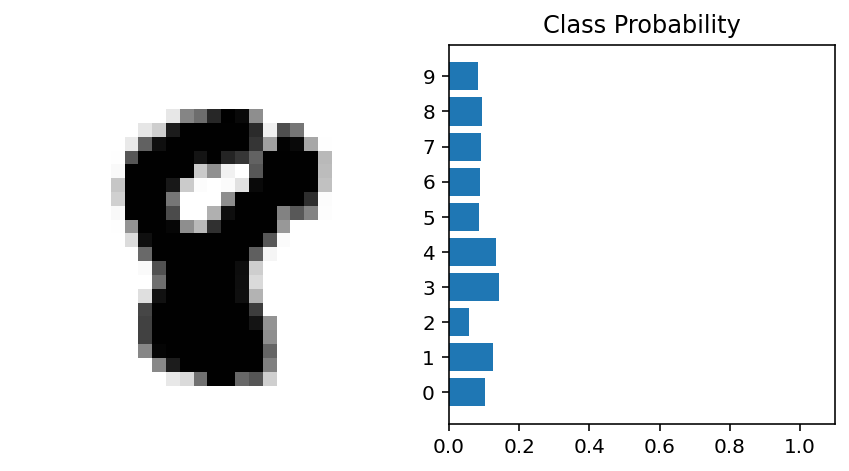

In [16]:
from random import randrange
r_img = randrange(batch_size)

for image_batch, label_batch in training_batches.take(1):
    ps = model_2.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[r_img]


fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

___

The `tf.keras.Sequential` model is a simple stack of layers that cannot be used to create arbitrary models. Luckily, `tf.keras` gives us the flexibility to build fully-customizable models by subclassing the `tf.keras.Model` and defining our own forward pass.

In [17]:
class Network(tf.keras.Model):
    def __init__(self, num_classes = 2):
        super().__init__()
        self.num_classes = num_classes
    
        # Define layers 
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden_layer = tf.keras.layers.Dense(256, activation = 'relu')
        self.output_layer = tf.keras.layers.Dense(self.num_classes, activation = 'softmax')
    
    # Define forward Pass   
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
    
        return x

In [18]:
model_3 = Network(10)

# BUILD ==> initialize the model's weights and biases
# Remember that `None` is used to indicate that any integer may be expected --> any batch size is acceptable 
model_3.build((None, 28, 28, 1))

model_3.summary()

Model: "network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_5 (Dense)             multiple                  200960    
                                                                 
 dense_6 (Dense)             multiple                  2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [19]:
class My_Network(tf.keras.Model):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.num_classes = num_classes
    
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden_1 = tf.keras.layers.Dense(128, activation = 'relu')
        self.hidden_2 = tf.keras.layers.Dense(64, activation = 'relu')
        self.output_layer = tf.keras.layers.Dense(self.num_classes, activation = 'softmax')
    
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.output_layer(x)
    
        return x

#################################
model_4 = My_Network()

model_4.build((None, 28, 28, 1))

model_4.summary()

Model: "my__network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_7 (Dense)             multiple                  100480    
                                                                 
 dense_8 (Dense)             multiple                  8256      
                                                                 
 dense_9 (Dense)             multiple                  650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


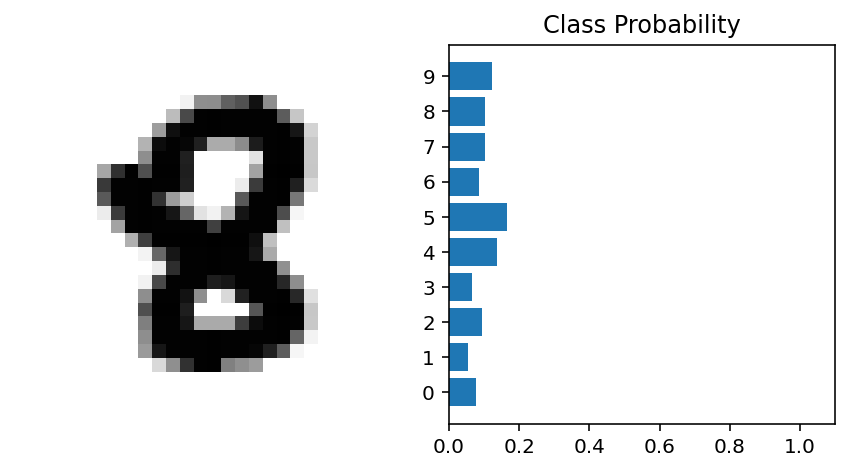

In [20]:
from random import randrange
r_img = randrange(batch_size)

for image_batch, label_batch in training_batches.take(1):
    ps = model_4.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[r_img]

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

___

This networks aren't so smart, they don't know anything about our handwritten digits. 

Neural networks with non-linear activations work like universal function approximators. At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We'll find this minimum using **gradient descent**.

For single layer networks, **gradient descent** is straightforward to implement. However, it's more complicated for deeper, multilayer neural networks like the ones we've built.

Training multilayer networks is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

To train the weights with gradient descent, we propagate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

**Note:** I'm glossing over a few details here that require some knowledge of vector calculus, but they aren't necessary to understand what's going on.

We update our weights using this gradient with some learning rate $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.

___

In [21]:
# let's take a look at how our last model performs when it is just using random weights
# ADAM is an optimization of the stochastic gradient descent algorithm
# we use use `sparse_categorical_crossentropy` loss function when our dataset has labels that are integers

model_4.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model_4.evaluate(image_batch, label_batch)

print('\nLoss before training: {:,.3f}'.format(loss))
print('Accuracy before training: {:.3%}'.format(accuracy))

2/2 [==============================] - 0s 3ms/step - loss: 2.2941 - accuracy: 0.1406

Loss before training: 2.294
Accuracy before training: 14.062%


In [22]:
EPOCHS = 5

history = model_4.fit(training_batches, epochs = EPOCHS)

for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model_4.evaluate(image_batch, label_batch)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

Epoch 1/5
938/938 [==============================] - 5s 4ms/step - loss: 0.2806 - accuracy: 0.9182
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1128 - accuracy: 0.9658
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0786 - accuracy: 0.9758
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0588 - accuracy: 0.9818
Epoch 5/5
2/2 [==============================] - 0s 3ms/step - loss: 0.0284 - accuracy: 0.9844

Loss after training: 0.028
Accuracy after training: 98.438%


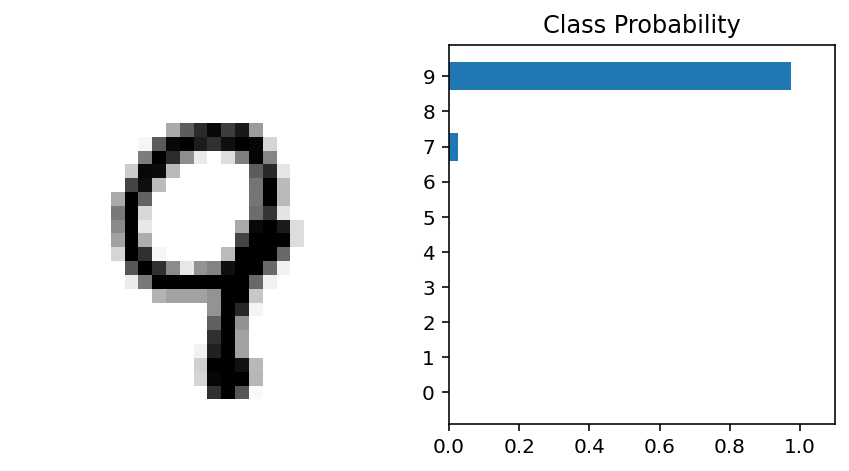

In [23]:
r_img = randrange(batch_size)

for image_batch, label_batch in training_batches.take(1):
    ps = model_4.predict(image_batch)
    some_image = image_batch.numpy().squeeze()[r_img]  

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(some_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[r_img])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

___

TensorFlow calculates and keeps track of the gradients needed for backpropagation, it provides a class that records *automatic differentiation* operations, called `tf.GradientTape`.

> Autodiff: a family of techniques used by computers for efficiently and accurately evaluating derivatives of numeric functions

`tf.GradientTape` works by keeping track of operations performed on tensors that are being "watched". By default, it will automatically "watch" any trainable variables, such as the weights in our model. 

Trainable variables are those that have `trainable=True`. When we create a model with `tf.keras`, all of the parameters are initialized this way. Any tensor can also be manually "watched" by invoking the watch method.

To know more about `tf.GradientTape` and trainable variables check the following links

* [Gradient Tape](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape)

* [TensorFlow Variables](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/Variable)